In [112]:
import time
import cv2
import os
import keras
import pandas as pd
import random
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.enable_eager_execution()

In [2]:
# parameters
BUFFER_SIZE = 400
BATCH_SIZE = 30
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [22]:
#Test directory
test_dir = 'C:/Users/n3rDx/Desktop/Homework Upload/Capstone/images/test/test'

# function to split training set X train, y train and produce augmented images       
def load_train(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    #randomly flip images up or down
    image = tf.image.random_flip_up_down(image)
    X_train = tf.cast(image, tf.float32)
    y_train = tf.cast(image, tf.float32)
    #change to X_train to gray ; y_train as target color itself
    X_train = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(X_train))
    #normalize to scales of -1 and 1
    X_train = (X_train/127.5) -1
    y_train = (y_train/127.5) -1
    
    return X_train, y_train
  
def load_test(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    X_train = tf.cast(image, tf.float32)
    y_train = tf.cast(image, tf.float32)
    #change to X_train to gray ; y_train as target color itself
    X_train = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(X_train))
    #normalize to scales of -1 and 1
    X_train = (X_train/127.5) -1
    y_train = (y_train/127.5) -1
    
    return X_train, y_train

In [45]:
test_dataset = tf.data.Dataset.list_files(test_dir+'/*.jpg')
test_dataset = test_dataset.map(load)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

In [24]:
# Custom convu filter to downsample image
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
            tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [25]:
# Custom convu filter to upsample image
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [26]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
          ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
          ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs

  # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [28]:
generator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)

In [29]:
# Define lambda from article  
lamb = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [31]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    #SSIM loss
    s_loss = ssim_loss(gen_output, target)
    
    #tf.image.ssim_multiscale
    
    tf_s_loss =  1 - tf.reduce_mean(tf.image.ssim_multiscale(gen_output, target, 1))
    
    total_gen_loss = gan_loss + (lamb * l1_loss)

    return total_gen_loss

In [32]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [33]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        print(disc_loss)
        track_gen_loss = tf.summary.scalar("Generator's Loss", gen_loss)
        track_disc_loss = tf.summary.scalar("Discriminator's Loss", disc_loss)

    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [34]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for input_image, target in dataset:
            train_step(input_image, target)

        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)
            
        # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix) 
            
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [35]:
generator = Generator()
discriminator = Discriminator()

In [47]:
checkpoint_dir = '../Capstone/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [48]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
train(train_dataset, epochs=1)

In [ ]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset.take(30):
    generate_images(generator, inp, tar)

In [14]:
import pandas as pd
df = pd.read_csv('loss_csv80.csv')

In [15]:
df.tail()

,Unnamed: 0,Generator Loss per step,Discriminator Loss per step
21923,21923,7.292889,1.078386
21924,21924,7.022666,1.333862
21925,21925,7.097198,1.161247
21926,21926,6.675115,1.083007
21927,21927,6.638663,1.425874


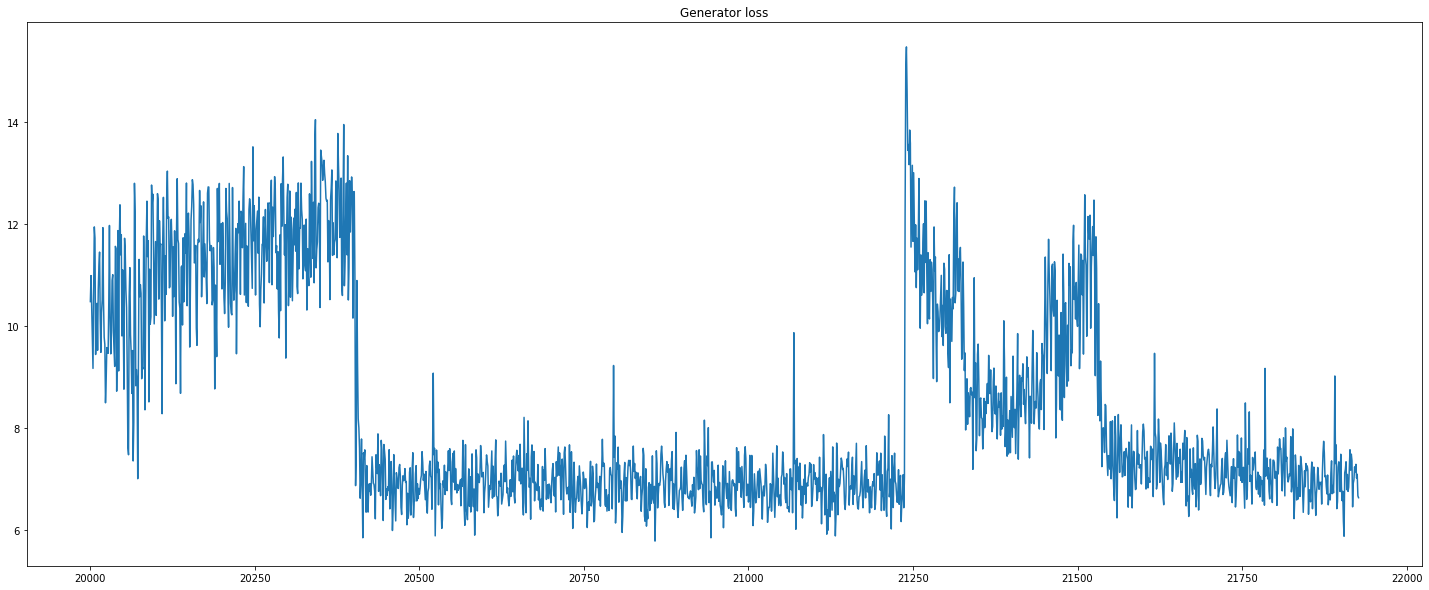

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(25,10))

plt.plot(df['Generator Loss per step'][20000:])
plt.title("Generator loss")
plt.show()


Text(0.5, 1.0, 'Discriminator loss')

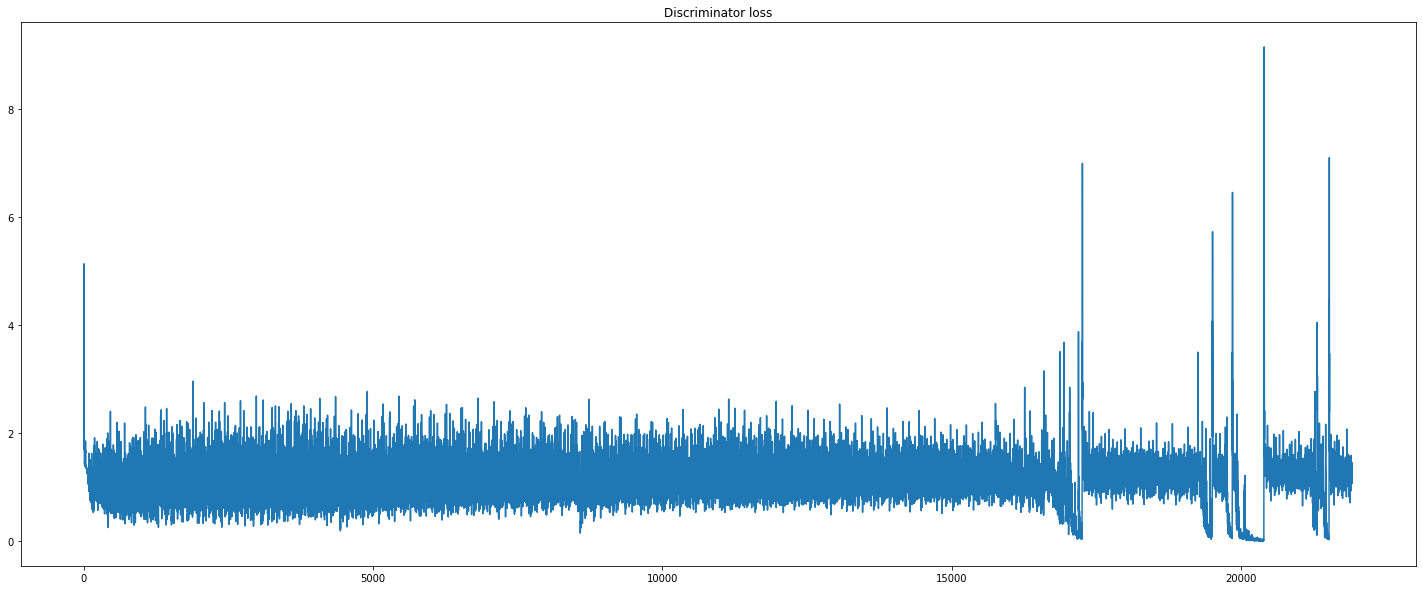

In [19]:

plt.figure(figsize=(25,10))

plt.plot(df['Discriminator Loss per step'])
plt.title('Discriminator loss')